Ignore this section if using on kaggle

In [30]:
!kaggle competitions download -c tensorflow-great-barrier-reef -p kaggle/input
!unzip -d kaggle/input tensorflow-great-barrier-reef.zip


tensorflow-great-barrier-reef.zip: Skipping, found more recently modified local copy (use --force to force download)
unzip:  cannot find or open tensorflow-great-barrier-reef.zip, tensorflow-great-barrier-reef.zip.zip or tensorflow-great-barrier-reef.zip.ZIP.


# Import Libraries

In [20]:
import os
import cv2
import random

import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

tqdm.pandas()
import sys

import matplotlib.pyplot as plt
from IPython.display import  display

from skimage.color import rgb2hsv, hsv2rgb
import numpy as np

sys.path.append('../input/tensorflow-great-barrier-reef')


### Constants

In [27]:
REMOVE_NOBBOX = True # remove training images with no bbox

RECOVER_HE = True
RECOVER_CLAHE = True
RECOVER_GC = True
RECOVER_ICM = False

# -- Directories --
ROOT_DIR = 'kaggle/input/tensorflow-great-barrier-reef'
IMAGE_DIR = 'kaggle/images'  # directory to save images
LABEL_DIR = 'kaggle/labels'  # directory to save labels

In [3]:
!mkdir -p {IMAGE_DIR}
!mkdir -p {LABEL_DIR}

In [12]:
# Train Data
df = pd.read_csv(f'{ROOT_DIR}/train.csv')
df['old_image_path'] = f'{ROOT_DIR}/train_images/video_'+df.video_id.astype(str)+'/'+df.video_frame.astype(str)+'.jpg'
df['image_path']  = f'{IMAGE_DIR}/'+df.image_id+'.jpg'
df['label_path']  = f'{LABEL_DIR}/'+df.image_id+'.txt'
df['annotations'] = df['annotations'].progress_apply(eval)
display(df.head())

  0%|          | 0/23501 [00:00<?, ?it/s]

video_id  sequence  video_frame  sequence_frame image_id annotations  \
0         0     40258            0               0      0-0          []   
1         0     40258            1               1      0-1          []   
2         0     40258            2               2      0-2          []   
3         0     40258            3               3      0-3          []   
4         0     40258            4               4      0-4          []   

                                      old_image_path             image_path  \
0  kaggle/input/tensorflow-great-barrier-reef/tra...  kaggle/images/0-0.jpg   
1  kaggle/input/tensorflow-great-barrier-reef/tra...  kaggle/images/0-1.jpg   
2  kaggle/input/tensorflow-great-barrier-reef/tra...  kaggle/images/0-2.jpg   
3  kaggle/input/tensorflow-great-barrier-reef/tra...  kaggle/images/0-3.jpg   
4  kaggle/input/tensorflow-great-barrier-reef/tra...  kaggle/images/0-4.jpg   

              label_path  
0  kaggle/labels/0-0.txt  
1  kaggle/labels/0-1.txt  
2  kaggle/labels/0-2.txt  
3  kaggle/labels/0-3.txt  
4  kaggle/labels/0-4.txt

### Clean Data

In [13]:
def RecoverHE(sceneRadiance):
    for i in range(3):
        sceneRadiance[:, :, i] = cv2.equalizeHist(sceneRadiance[:, :, i])
    return sceneRadiance


def RecoverCLAHE(sceneRadiance):
    clahe = cv2.createCLAHE(clipLimit=7, tileGridSize=(14, 14))
    for i in range(3):

        sceneRadiance[:, :, i] = clahe.apply((sceneRadiance[:, :, i]))

    return sceneRadiance

def RecoverGC(sceneRadiance):
    sceneRadiance = sceneRadiance/255.0

    for i in range(3):
        sceneRadiance[:, :, i] = np.power(
            sceneRadiance[:, :, i] / float(np.max(sceneRadiance[:, :, i])), 3.2)
    sceneRadiance = np.clip(sceneRadiance*255, 0, 255)
    sceneRadiance = np.uint8(sceneRadiance)
    return sceneRadiance


def global_stretching(img_L, height, width):
    I_min = np.min(img_L)
    I_max = np.max(img_L)

    array_Global_histogram_stretching_L = np.zeros((height, width))
    for i in range(0, height):
        for j in range(0, width):
            p_out = (img_L[i][j] - I_min) * ((1) / (I_max - I_min))
            array_Global_histogram_stretching_L[i][j] = p_out

    return array_Global_histogram_stretching_L


def stretching(img):
    height = len(img)
    width = len(img[0])
    for k in range(0, 3):
        Max_channel = np.max(img[:, :, k])
        Min_channel = np.min(img[:, :, k])
        for i in range(height):
            for j in range(width):
                img[i, j, k] = (img[i, j, k] - Min_channel) * \
                    (255 - 0) / (Max_channel - Min_channel) + 0
    return img


def HSVStretching(sceneRadiance):
    height = len(sceneRadiance)
    width = len(sceneRadiance[0])
    img_hsv = rgb2hsv(sceneRadiance)
    h, s, v = cv2.split(img_hsv)
    img_s_stretching = global_stretching(s, height, width)

    img_v_stretching = global_stretching(v, height, width)

    labArray = np.zeros((height, width, 3), 'float64')
    labArray[:, :, 0] = h
    labArray[:, :, 1] = img_s_stretching
    labArray[:, :, 2] = img_v_stretching
    return hsv2rgb(labArray) * 255

def sceneRadianceRGB(sceneRadiance):

    sceneRadiance = np.clip(sceneRadiance, 0, 255)
    sceneRadiance = np.uint8(sceneRadiance)

    return sceneRadiance

def RecoverICM(img1):
    img = stretching(img1)
    sceneRadiance = sceneRadianceRGB(img)
    sceneRadiance = HSVStretching(sceneRadiance)
    sceneRadiance = sceneRadianceRGB(sceneRadiance)

    return sceneRadiance


In [28]:
df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))

if REMOVE_NOBBOX:
    df = df.query("num_bbox>0")


def make_copy(row):
    image = cv2.imread(row.old_image_path)
    image = pipeline(image)
    cv2.imwrite(row.image_path, image)
    return

image_paths = df.old_image_path.tolist()
_ = Parallel(n_jobs=-1, backend='threading')(delayed(make_copy)(row)
                                             for _, row in tqdm(df.iterrows(), total=len(df)))


  0%|          | 0/4919 [00:00<?, ?it/s]

  0%|          | 0/4919 [00:00<?, ?it/s]

In [7]:
def plot_img_tf(img_dir, num_items, func, mode):
    img_list = random.sample(os.listdir(img_dir), num_items)
    full_path = img_dir + '/' + img_list[0]
    img_temp_plt = plt.imread(full_path)
    img_temp_cv = cv2.imread(full_path)
    for i in range(0, len(img_list)):
        full_path = img_dir + '/' + img_list[i]
        img_temp_plt = plt.imread(full_path)
        img_temp_cv = cv2.imread(full_path)
        plt.figure(figsize=(20, 15))
        if mode == "plt":
            img_stack = np.hstack((img_temp_plt, func(np.copy(img_temp_plt))))
            plt.imshow(img_stack)
        if mode == "cv2":
            img_stack = np.hstack((img_temp_cv, func(np.copy(img_temp_plt))))
            plt.imshow(img_stack)
        plt.axis("off")
        plt.show()


In [25]:
def pipeline(img):
    if RECOVER_HE:
        img = RecoverHE(img)
    if RECOVER_GC:
        img = RecoverGC(img)
    if RECOVER_CLAHE:
        img = RecoverCLAHE(img)
    if RECOVER_ICM:
        img = RecoverICM(img)

    return img

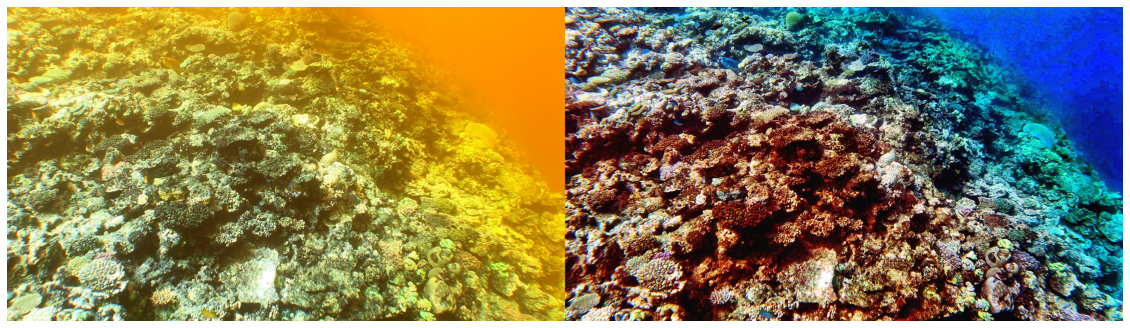

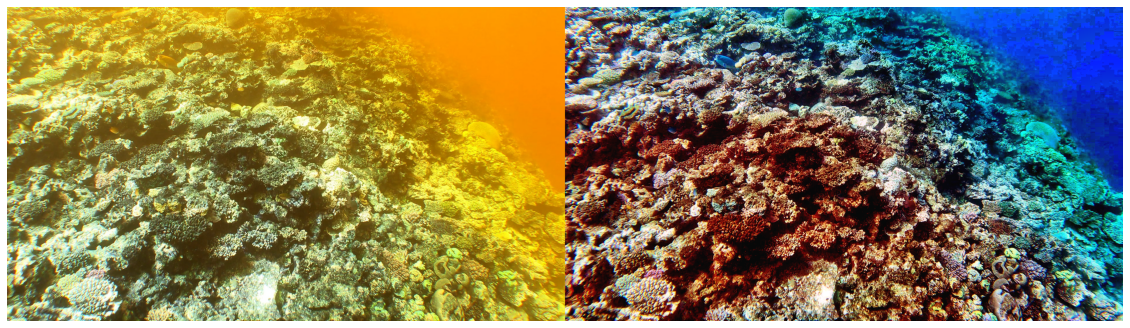

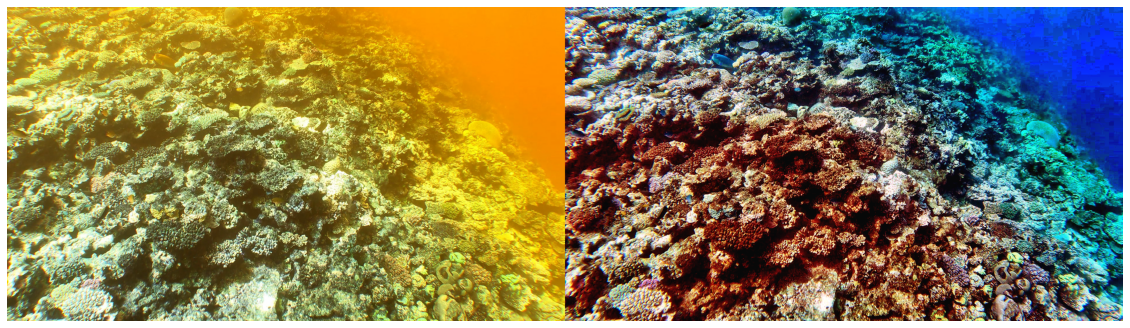

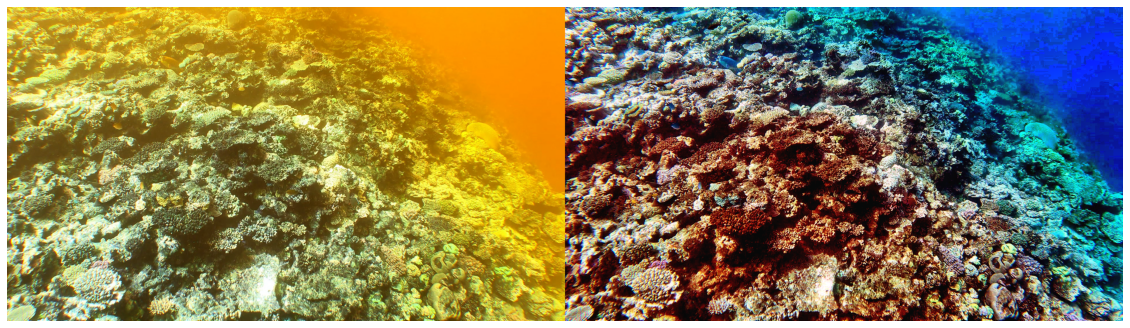

In [26]:
img_dir = "./kaggle/samples"
num_items = 4
plot_img_tf(img_dir,num_items, pipeline,"cv2")